In [1]:
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import numpy as np
import tempfile
import imageio
import shutil
import os
from statistics import mean
import pandas as pd 
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 
from gensim.test.utils import datapath
from gensim.models.fasttext import load_facebook_vectors
from gensim.models import FastText

from IPython.display import Image
from IPython.display import display
pd.options.display.max_columns = None
import seaborn as sns
from itertools import combinations

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import sys
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
print(gensim.__version__)
print("You are using Python {}.{}.".format(sys.version_info.major, sys.version_info.minor))

/home/slavkoz/anaconda3/envs/offensive-language-organization/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


4.0.1
You are using Python 3.6.


### Constants

In [2]:
DATASETS_FOLDER = "/Users/slavkoz/OneDrive - Univerza v Ljubljani/Datasets/Offensive language datasets/PROCESSED_DATA/"

TOP_N = 30
KEYS = { \
   "simile": set(), 
   "irony": set(), 
   "sarcasm": set(), 
   "metaphor": set(), 
   "exaggeration": set(), 
   "overstatement": set(), 
   "understatement": set(),
   "rather": set(),
   "truly": set(),
   "indeed": set(),
   "real": set(),
   "always": set(),
   "indeed": set(),
   "never": set(),
   "clearly": set(),
   "certainly": set(),
   "definitely": set(),
   "evidently": set(),
   "obviously": set(),
   "really": set(),
   "brilliant": set(),
   "absolute": set(),
   "genius": set(),
   "miracle": set()
}
FIXED_KEYS = list(KEYS.keys())

In [3]:
print(FIXED_KEYS)

['simile', 'irony', 'sarcasm', 'metaphor', 'exaggeration', 'overstatement', 'understatement', 'rather', 'truly', 'indeed', 'real', 'always', 'never', 'clearly', 'certainly', 'definitely', 'evidently', 'obviously', 'really', 'brilliant', 'absolute', 'genius', 'miracle']


Too similar words that will not be taken into account as neighbouring words:

In [4]:
lemmatizer = WordNetLemmatizer() 
ps = PorterStemmer() 


for key in KEYS.keys():
    lemma = lemmatizer.lemmatize(key)
    stem = ps.stem(key)
    KEYS[key].add(lemma)
    KEYS[key].add(stem)
    KEYS[key].add(key)
KEYS

{'simile': {'simil', 'simile'},
 'irony': {'ironi', 'irony'},
 'sarcasm': {'sarcasm'},
 'metaphor': {'metaphor'},
 'exaggeration': {'exagger', 'exaggeration'},
 'overstatement': {'overstat', 'overstatement'},
 'understatement': {'understat', 'understatement'},
 'rather': {'rather'},
 'truly': {'truli', 'truly'},
 'indeed': {'inde', 'indeed'},
 'real': {'real'},
 'always': {'alway', 'always'},
 'never': {'never'},
 'clearly': {'clearli', 'clearly'},
 'certainly': {'certainli', 'certainly'},
 'definitely': {'definit', 'definitely'},
 'evidently': {'evid', 'evidently'},
 'obviously': {'obvious', 'obviously'},
 'really': {'realli', 'really'},
 'brilliant': {'brilliant'},
 'absolute': {'absolut', 'absolute'},
 'genius': {'geniu', 'genius'},
 'miracle': {'miracl', 'miracle'}}

### Functions

In [5]:
def same_word(similar_word, ommit_words):
    similar_word = similar_word.replace("_", " ").replace("-", " ").lower()
    
    if similar_word in ommit_words:
        print(f"{ommit_words} -- {similar_word}")
        return True
    
    for ommit_word in ommit_words:
        if ommit_word in similar_word:
            print(f"{ommit_words} -- {similar_word}")
            return True
        
    return False

In [6]:
def getSimilarWords(model_gn):
    embedding_clusters = []
    word_clusters = []
    for key in FIXED_KEYS:
        ommit_words = KEYS[key]
        embeddings = []
        words = []
        for similar_word, _ in model_gn.wv.most_similar(key, topn=TOP_N * 3):
            if not same_word(similar_word, ommit_words):
                words.append(similar_word)
                embeddings.append(model_gn.wv[similar_word])
                
        if len(words) < TOP_N or len(embeddings) < TOP_N:
            print("ERROR")
            
        words = words[:TOP_N]
        embeddings = embeddings[:TOP_N]
        
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    return (word_clusters, embedding_clusters)

In [7]:
def displayDF(word_clusters):
    df = pd.DataFrame(dict(zip(FIXED_KEYS, word_clusters)))  
    df.to_csv('outputs/offensiveV1.csv')
    display(df)

In [8]:
def plot_similar_words(title, labels, embedding_clusters, word_clusters, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=0.7, label=label)
        for i, word in enumerate(words):              
            plt.annotate(label.upper(), alpha=1.0, xy=(mean(x), mean(y)), xytext=(0, 0),
            textcoords='offset points', ha='center', va='center', size=15)
    plt.legend(loc=0)
    plt.title(title)
    plt.grid(False)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
def plotTSNE(title, word_clusters, embedding_clusters,  filename = None):
    perp = 15
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [10]:
def plotMDS(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = MDS(n_components=2, max_iter=3500, random_state=32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)

In [11]:
def plotPCA(title, word_clusters, embedding_clusters, filename = None):
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    model_en_2d = PCA(n_components=2, random_state = 32)
    model_en_2d = model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))
    embeddings_en_2d = np.array(model_en_2d).reshape(n, m, 2)
    plot_similar_words(title, FIXED_KEYS, embeddings_en_2d, word_clusters, filename)
    

{'exaggeration', 'exagger'} -- exaggerated
{'real'} -- reality
{'evid', 'evidently'} -- evident
{'obviously', 'obvious'} -- obvious


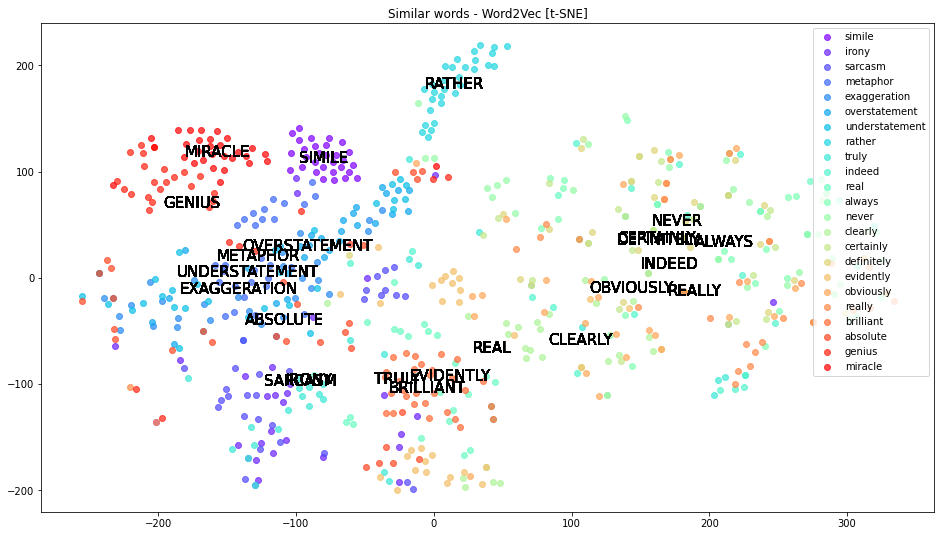

In [12]:
model_gn = Word2Vec.load("outputs/w2v_50dim_model_v2")
listOfWords = FIXED_KEYS
word_clusters, embedding_clusters = getSimilarWords(model_gn)
plotTSNE("Similar words - Word2Vec [t-SNE]", word_clusters, embedding_clusters, "outputs/SimilarWords - word2vec - t-SNE.png")

In [13]:
def exprtWords(word,model):
    res =  model.wv.most_similar(word, topn=30)
    return [(word,x[0],x[1]) for x in res]
   

## Word2Vec

Loading model

In [14]:
import re
def exportToCsv(name,dic):
    with open('{}.csv'.format(name) , 'w', encoding='utf8') as w:
        for k,x in dic.items():
             w.write('{},{}\n'.format(k,",".join(x)))

def cleanKeywords(txt):
    return re.sub("\\\\",'',txt)
#     return re.sub("[^a-zA-Z]",'',txt)

def filterCsvByKeywords(_df, keyWords, orig):
    newDf = pd.DataFrame()
    for K in keyWords:
        keyWord = cleanKeywords(K)
        #         res = _df[_df['text'].isin([keyWords])]
        res = _df[_df['text'].str.contains(" {} ".format(keyWord), na=False)]
#         res = _df.filter(like= keyWord, axis=1)
        res['relatedWord'] = keyWord

        if newDf.empty:
            newDf = res

        else:
            newDf = pd.concat([newDf,res])
    newDf.to_csv('outputs/{}_examples.csv'.format(orig))


Load models

## build heatmap


In [15]:
##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df_hm, xlabels, ylabels):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    f, ax = plt.subplots(figsize=(18, 18))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5,
            xticklabels=xlabels, yticklabels=ylabels,
            square=True, linewidths=.5, fmt='.2f',
            annot=True, annot_kws={"fontsize":14}, cbar_kws={"shrink": .5}, vmax=1)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize =15)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize =15)

    #     ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='left')

#     ax.set_title("Heatmap of cosine similarity scores")
    ax.set_xlabel("")
    ax.set_ylabel("")

    return ax


def similartyHeatmapPairs(pairs,model):
    '''return ((word1,word2),simScore)'''
    return [(x,model.wv.similarity(*x)) for x in pairs]
###################
# model_gn = FastText.load("")
###################
print(len(listOfWords))
listOfWordsCombinations = list(combinations(listOfWords,2))

def buildHeatmap(listCombinations,model_gn):
    similartyHeatmapData = similartyHeatmapPairs(listCombinations,model_gn)

    listOfWordsCombinationsDict = {x:k for k,x in enumerate(listOfWords)}

    p,s = zip(*similartyHeatmapData)

    df = pd.DataFrame({'pair': p, 'similarity': s})
    df_tmp =[(listOfWordsCombinationsDict.get(k[0]),listOfWordsCombinationsDict.get(k[1]),v) for k ,v in similartyHeatmapData]
    df_hm = pd.DataFrame({'ind': range(7), 'cols': range(7), 'vals': pd.Series(np.zeros(7))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols').fillna(0)
    # to get lower diagnol, swap the rows and cols.
    for row, col, similarity in df_tmp:
        df_hm.iloc[col, row] = similarity
    ids = list(listOfWordsCombinationsDict.keys())
    ax = plot_heatmap(df_hm, ids, ids)
    

23


In [17]:
# use model that support model.wv.similarity(word1,word2)
#buildHeatmap(listOfWordsCombinations,model_gn)

In [19]:
###################
model_ft = FastText.load("outputs/fastText_50dim_model_v2")
###################
#buildHeatmap(listOfWordsCombinations,model_ft)

Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [20]:
word_clusters, embedding_clusters = getSimilarWords(model_ft)



{'simil', 'simile'} -- facsimile
{'simil', 'simile'} -- similacrum
{'simil', 'simile'} -- similair
{'simil', 'simile'} -- similitude
{'simil', 'simile'} -- similarit
{'simil', 'simile'} -- similie
{'irony', 'ironi'} -- ironybro
{'irony', 'ironi'} -- ironi
{'irony', 'ironi'} -- ironist
{'irony', 'ironi'} -- ironicly
{'irony', 'ironi'} -- ironinkpen
{'sarcasm'} -- sarcasms
{'metaphor'} -- metaphore
{'metaphor'} -- metaphoric
{'metaphor'} -- metaphorical
{'metaphor'} -- metaphorically
{'understatement', 'understat'} -- understate
{'rather'} -- rathergate
{'rather'} -- ratherbefishing
{'rather'} -- strathern
{'truly', 'truli'} -- slopes truly
{'indeed', 'inde'} -- indeeed
{'indeed', 'inde'} -- indent
{'indeed', 'inde'} -- unindent
{'indeed', 'inde'} -- unhindered
{'indeed', 'inde'} -- factfinder
{'real'} -- 4real
{'real'} -- :real
{'real'} -- w/real
{'real'} -- furreal
{'real'} -- l’oreal
{'real'} -- l'oreal
{'real'} -- kwawkesse4real
{'real'} -- cereal
{'real'} -- j4ezreal
{'real'} -- lor

In [21]:
displayDF(word_clusters)

,simile,irony,sarcasm,metaphor,exaggeration,overstatement,understatement,rather,truly,indeed,real,always,never,clearly,certainly,definitely,evidently,obviously,really,brilliant,absolute,genius,miracle
0,lestrange,iron2,apologism,metamorphosis,exageration,understatement,overstatement,rathe,trully,incedent,big-reveal,allways,n-ever,bizarrely,definitely,certainly,fraudulently,obviosly,reallly,briliant,absolte,geniet,l'oracle
1,émile,ironfx,logicus,metapcj,exagerration,misstatement,understandment,rathke,truthfuly,concidered,bigdeal,neveryield,5ever,inconsistently,surely,surely,absently,obvisously,realllly,brilliancy,absoloute,genieo,#oracle
2,strangle,irongron,sarcastic,metatlollacl,obliteration,mis-statement,misstatement,more,truely,not-too-distant,fudbal,everyway,ever,obviouslly,cetainly,probably,abundently,obviuously,reallllly,briant,abso-,geniva,monocle
3,simialr,ironduke,misbehaviour,metallicity,absorbtion,pov-statement,mis-statement,slather,goodthingyourepretty,sutdent,neal,a-lways,4ever,obviously,vainly,definately,#apparently,obiviously,realy,brillian,abolute,genin,bocle
4,siliconangle,ironman,soph,sterotype,infixation,abatement,assumption,more-or,sadly,devastatingly,biggestrespect,neverhappyever,...ever,inaccurately,necesarily,probalbly,apparently,unfotunately,reallllllly,valliant,utter,genio,gristle
5,difuzarile,iron,misconstrude,metairie,deflation,incitement,interpretation,morer,jobless,notsparxent,mega-meal,neverever,iveever,succinctly,arguably,cetainly,incompetently,unfounately,reallt,fantastic,abso,hephaestus,croyle
6,varmint,crony,pruetrude,shemeta,provokation,restatement,understimate,more-,intellectually,underestimating,feal,nowomanever,hever,factly,certaintly,uncertainly,reciently,enviously,ideally,brillant,solute,diophantus,miricle
7,mallus,ironboy,fauxffense,symetis,evisceration,assumption,acknowledgment,moreju,morally,veulent,prosthetic,bestthingever,hwoever,apparently,neccessarily,probablly,patently,obliviously,honestly,bint-glazing,absorb,phatius,bristle
8,netrange,iron-clad,apolgism,metaverse,divulgation,excetement,interpretation==,more*,spiritually,ingredient,biggus,everywhen,hayfever,disputatious,certanly,definietly,deviously,obviosuly,reallү,bwilliant,uttereth,geni,creole
9,tensile,ironruby,misbehavior,pseudovector,abbrevation,incomptence,acknowledgement,rathead,faithless,condsidered,immortal,thingsyoushouldneverassume,neve,explictly,nescessarily,defintely,preposterously,apparantly,reaaalllly,marvellous,absue,gendelman,oracle


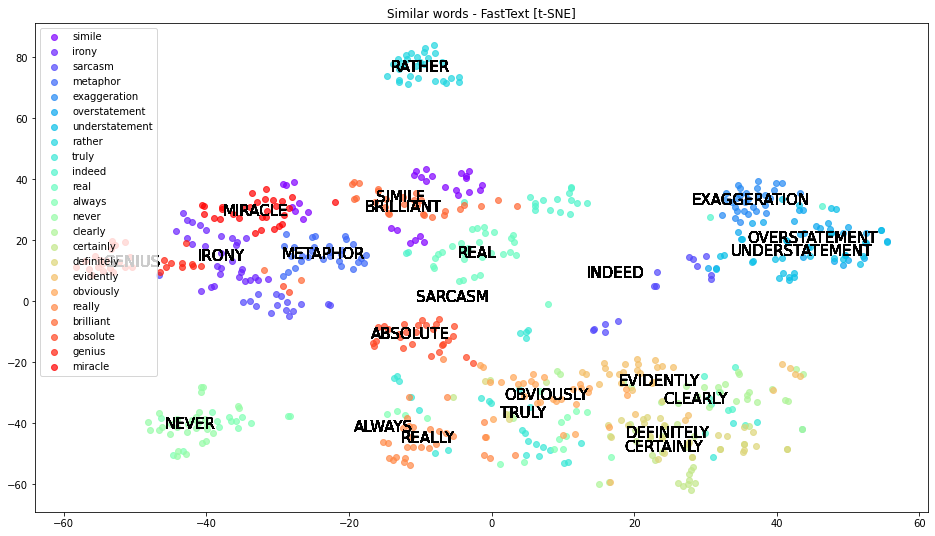

In [22]:
plotTSNE("Similar words - FastText [t-SNE]", word_clusters, embedding_clusters, "outputs/SimilarWords - fastText_50_v2 - t-SNE.png")

In [23]:
#plotMDS("Similar words - Word2Vec [MDS]", word_clusters, embedding_clusters, "outputs/SimilarWords - word2vec - MDS.png")

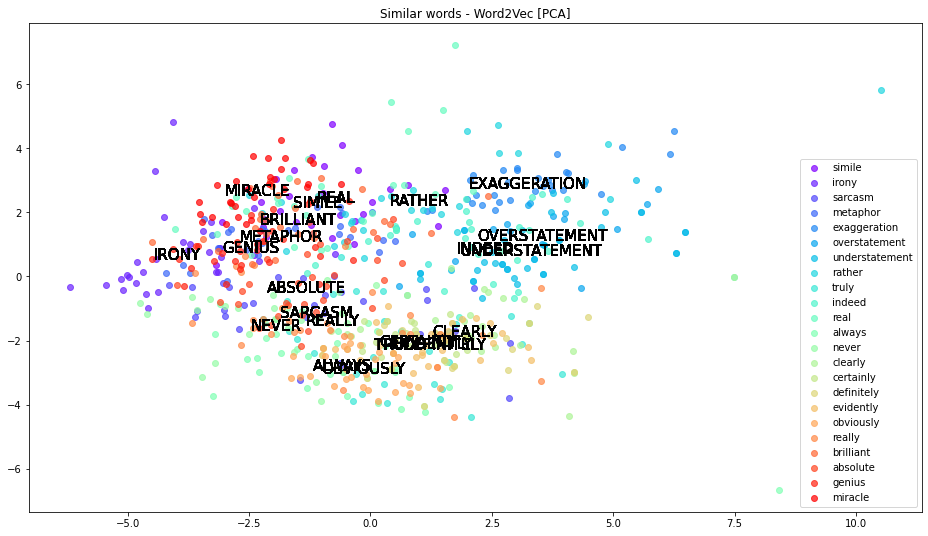

In [24]:
plotPCA("Similar words - Word2Vec [PCA]", word_clusters, embedding_clusters, "outputs/SimilarWords - word2vec - PCA.png")

## fastText

Loading model

In [25]:
model_gn = FastText.load("outputs/fastText_50dim_model_v2")

In [26]:
#print(f"Vocabulary size: {len(model_gn.vocab)}")

Getting similar words. Printed out words are neighboring words that are ommited for the analysis.

In [27]:
word_clusters, embedding_clusters = getSimilarWords(model_gn)

{'simil', 'simile'} -- facsimile
{'simil', 'simile'} -- similacrum
{'simil', 'simile'} -- similair
{'simil', 'simile'} -- similitude
{'simil', 'simile'} -- similarit
{'simil', 'simile'} -- similie
{'irony', 'ironi'} -- ironybro
{'irony', 'ironi'} -- ironi
{'irony', 'ironi'} -- ironist
{'irony', 'ironi'} -- ironicly
{'irony', 'ironi'} -- ironinkpen
{'sarcasm'} -- sarcasms
{'metaphor'} -- metaphore
{'metaphor'} -- metaphoric
{'metaphor'} -- metaphorical
{'metaphor'} -- metaphorically
{'understatement', 'understat'} -- understate
{'rather'} -- rathergate
{'rather'} -- ratherbefishing
{'rather'} -- strathern
{'truly', 'truli'} -- slopes truly
{'indeed', 'inde'} -- indeeed
{'indeed', 'inde'} -- indent
{'indeed', 'inde'} -- unindent
{'indeed', 'inde'} -- unhindered
{'indeed', 'inde'} -- factfinder
{'real'} -- 4real
{'real'} -- :real
{'real'} -- w/real
{'real'} -- furreal
{'real'} -- l’oreal
{'real'} -- l'oreal
{'real'} -- kwawkesse4real
{'real'} -- cereal
{'real'} -- j4ezreal
{'real'} -- lor

In [28]:
displayDF(word_clusters)

,simile,irony,sarcasm,metaphor,exaggeration,overstatement,understatement,rather,truly,indeed,real,always,never,clearly,certainly,definitely,evidently,obviously,really,brilliant,absolute,genius,miracle
0,lestrange,iron2,apologism,metamorphosis,exageration,understatement,overstatement,rathe,trully,incedent,big-reveal,allways,n-ever,bizarrely,definitely,certainly,fraudulently,obviosly,reallly,briliant,absolte,geniet,l'oracle
1,émile,ironfx,logicus,metapcj,exagerration,misstatement,understandment,rathke,truthfuly,concidered,bigdeal,neveryield,5ever,inconsistently,surely,surely,absently,obvisously,realllly,brilliancy,absoloute,genieo,#oracle
2,strangle,irongron,sarcastic,metatlollacl,obliteration,mis-statement,misstatement,more,truely,not-too-distant,fudbal,everyway,ever,obviouslly,cetainly,probably,abundently,obviuously,reallllly,briant,abso-,geniva,monocle
3,simialr,ironduke,misbehaviour,metallicity,absorbtion,pov-statement,mis-statement,slather,goodthingyourepretty,sutdent,neal,a-lways,4ever,obviously,vainly,definately,#apparently,obiviously,realy,brillian,abolute,genin,bocle
4,siliconangle,ironman,soph,sterotype,infixation,abatement,assumption,more-or,sadly,devastatingly,biggestrespect,neverhappyever,...ever,inaccurately,necesarily,probalbly,apparently,unfotunately,reallllllly,valliant,utter,genio,gristle
5,difuzarile,iron,misconstrude,metairie,deflation,incitement,interpretation,morer,jobless,notsparxent,mega-meal,neverever,iveever,succinctly,arguably,cetainly,incompetently,unfounately,reallt,fantastic,abso,hephaestus,croyle
6,varmint,crony,pruetrude,shemeta,provokation,restatement,understimate,more-,intellectually,underestimating,feal,nowomanever,hever,factly,certaintly,uncertainly,reciently,enviously,ideally,brillant,solute,diophantus,miricle
7,mallus,ironboy,fauxffense,symetis,evisceration,assumption,acknowledgment,moreju,morally,veulent,prosthetic,bestthingever,hwoever,apparently,neccessarily,probablly,patently,obliviously,honestly,bint-glazing,absorb,phatius,bristle
8,netrange,iron-clad,apolgism,metaverse,divulgation,excetement,interpretation==,more*,spiritually,ingredient,biggus,everywhen,hayfever,disputatious,certanly,definietly,deviously,obviosuly,reallү,bwilliant,uttereth,geni,creole
9,tensile,ironruby,misbehavior,pseudovector,abbrevation,incomptence,acknowledgement,rathead,faithless,condsidered,immortal,thingsyoushouldneverassume,neve,explictly,nescessarily,defintely,preposterously,apparantly,reaaalllly,marvellous,absue,gendelman,oracle


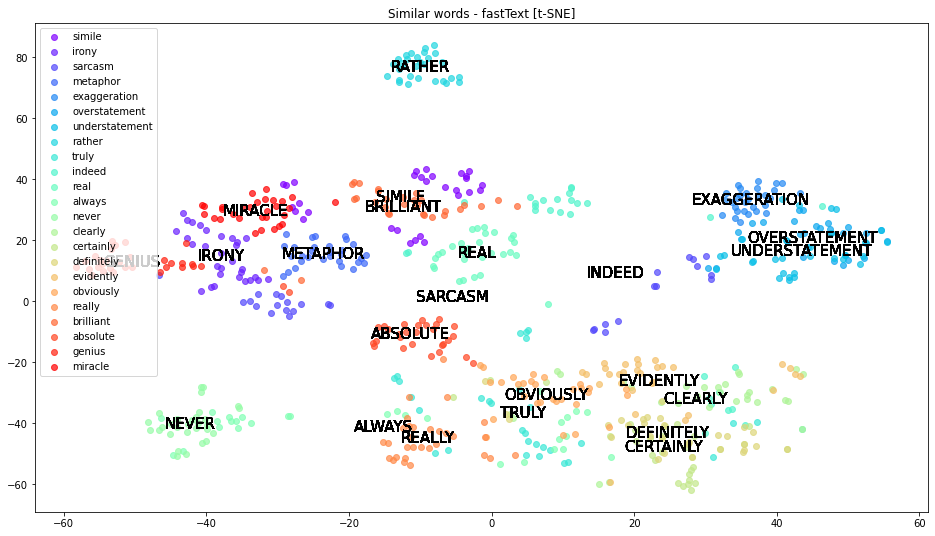

In [29]:
plotTSNE("Similar words - fastText [t-SNE]", word_clusters, embedding_clusters, "outputs/SimilarWords - fastText - t-SNE.png")

In [30]:
#plotMDS("Similar words - fastText [MDS]", word_clusters, embedding_clusters, "outputs/SimilarWords - fastText - MDS.png")

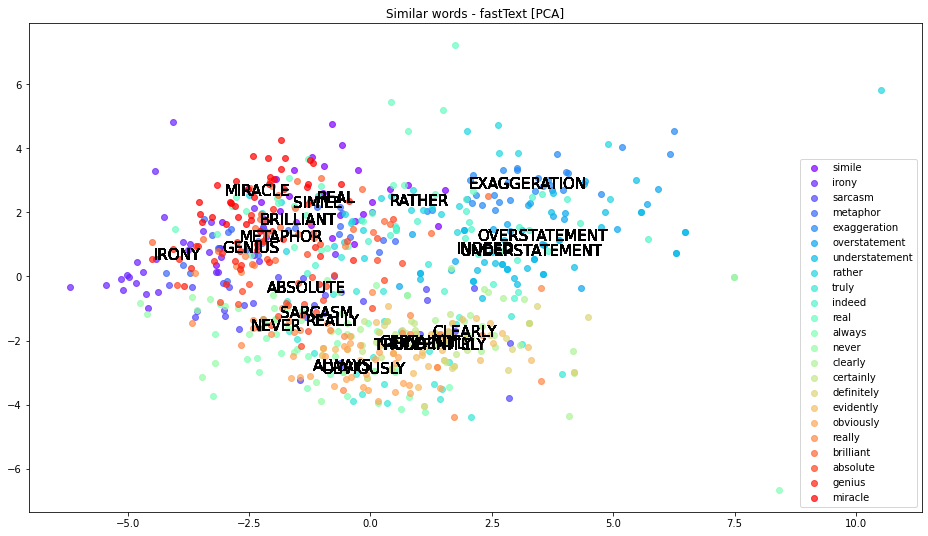

In [31]:
plotPCA("Similar words - fastText [PCA]", word_clusters, embedding_clusters, "outputs/SimilarWords - fastText - PCA.png")